## Import and Cleanup Data

In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
from sklearn.decomposition import PCA, FactorAnalysis
from factor_analyzer import FactorAnalyzer
from sklearn.cross_decomposition import CCA
import matplotlib.pyplot as plt
from mca import MCA
import sys
np.set_printoptions(threshold=sys.maxsize)


In [2]:
## If data already preprocessed, load it in, else do preprocessing

try:
    data = pd.read_csv('./data/finaltv.csv', index_col=0)
    test = pd.read_csv('./data/finaltest.csv', index_col=0)
    fc_test = pd.read_csv('./data/fc_test_10000.csv', index_col=0)
    print("Data successfully loaded")
except Exception:
    label, rev_index, features = pkl.load(open('./data/feature_index_all.pkl','rb'))
    Lindel_training = pd.read_csv("./data/Lindel_training_65bp.csv", sep=',', index_col=0)
    Lindel_test = pd.read_csv("./data/Lindel_test_65bp.csv", sep=',', index_col=0)

    print("Number of labels : ", len(label.keys()))
    print("Number of rev_index : ", len(rev_index.keys()))
    print("Number of features : ", len(features.keys()))

    # column descriptions
    # Lindel_training.iloc[0] # guide sequences
    # Lindel_training.iloc[1:3034] # 3033 binary features [2649 MH binary features + 384 one hot encoded features]
    # Lindel_training.iloc[3034:] # 557 observed outcome frequencies

    # # Merge training and test set for dimensionality reduction
    all_data = pd.concat([Lindel_training, Lindel_test])
    # data_features = all_data.iloc[:, 1:3034]

    # # Clean up data
    features = dict(sorted(features.items(), key=lambda item: item[1]))
    feature_labels = list(features.keys())

    labels = dict(sorted(label.items(), key=lambda item: item[1]))
    class_labels = list(labels.keys())

    one_hot_labels = []
    for i in range(80):
        one_hot_labels.append("nt {}".format(str(int(i / 4) + 1)))

    for i in range(304):
        one_hot_labels.append("2nt {}".format(str(int(i / 16) + 1)))

    one_hot_labels = np.array(one_hot_labels)

    column_labels = np.concatenate((np.array(['Guide Sequence', '65bp']), feature_labels, one_hot_labels, class_labels))

    # Rename columns of test and training set
    Lindel_training = Lindel_training.set_axis(column_labels, axis=1, inplace=False)
    Lindel_test = Lindel_test.set_axis(column_labels, axis=1, inplace=False)

    Lindel_training.to_csv('./data/finaltv.csv')
    Lindel_test.to_csv('./data/finaltest.csv')

    data = pd.concat([Lindel_training, Lindel_test], axis=0)


Data successfully loaded


## Run LINDEL Model, all configurations that do not require dimensionality reduction

In [3]:
# Do data preprocessing

import pickle as pkl
import os,sys,csv,re

from tqdm import tqdm_notebook as tqdm
import pylab as pl
import numpy as np
from datetime import datetime


from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Flatten
from keras.models import Sequential, load_model
from keras.regularizers import l2, l1
from sklearn.model_selection import KFold
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import *

# Make the data preprocessing a deterministic process
np.random.seed(42)

# Define useful functions
def mse(x, y):
    return ((x-y)**2).mean()

def corr(x, y):
    return np.corrcoef(x, y)[0, 1] ** 2

def onehotencoder(seq):
    nt= ['A','T','C','G']
    head = []
    l = len(seq)
    for k in range(l):
        for i in range(4):
            head.append(nt[i]+str(k))

    for k in range(l-1):
        for i in range(4):
            for j in range(4):
                head.append(nt[i]+nt[j]+str(k))
    head_idx = {}
    for idx,key in enumerate(head):
        head_idx[key] = idx
    encode = np.zeros(len(head_idx))
    for j in range(l):
        encode[head_idx[seq[j]+str(j)]] =1.
    for k in range(l-1):
        encode[head_idx[seq[k:k+2]+str(k)]] =1.
    return encode

def kfoldsplits(X):
    """Split annotations"""
    kf = KFold(n_splits=10, shuffle=False)
    splits = []
    for trainIdx, validIdx in kf.split(X):
        splits.append((trainIdx, validIdx))
        
    print("The first index of the first split is ", splits[0][0][0])

    return splits

# Preprocess data
model_data = data.values[:,2:].astype(np.float32)
test_data = test.values[:, 2:].astype(np.float32)
fc_data = fc_test.values[:, 1:].astype(np.float32)
print(model_data.shape, type(model_data))

# Sum up deletions and insertions to
X = model_data[:, :(2649 + 384)]
y = model_data[:, (2649 + 384):]

X_test = test_data[:, :(2649 + 384)]
y_test = test_data[:, (2649 + 384):]

X_fc = fc_data[:, :(2649 + 384)]
y_fc = fc_data[:, (2649 + 384):]

print("X Shape ", X.shape, " | y shape ", y.shape)
print("X_test Shape ", X_test.shape, " | y_test shape ", y_test.shape)
print("X_fc Shape ", X_fc.shape, " | y_fc shape ", y_fc.shape)


# Randomly shuffle data
idx = np.arange(len(y))
np.random.shuffle(idx)
X, y = X[idx], y[idx]
test_idx = np.arange(len(y_test))
np.random.shuffle(test_idx)
X_test, y_test = X_test[test_idx], y_test[test_idx]
fc_idx = np.arange(len(y_fc))
np.random.shuffle(fc_idx)
X_fc, y_fc = X_fc[fc_idx], y_fc[fc_idx]

print("Now removing samples with only insertion events")
X_deletion, y_deletion = [], []
X_test_deletion, y_test_deletion = [], []
X_fc_deletion, y_fc_deletion = [], []

# Remove samples that only have insertion events:
for i in range(model_data.shape[0]):
    if 1> sum(y[i,:536])> 0 :
        y_deletion.append(y[i,:536]/sum(y[i,:536]))
        X_deletion.append(X[i])
        
X_deletion, y_deletion = np.array(X_deletion), np.array(y_deletion)

for i in range(test_data.shape[0]):
    if 1> sum(y_test[i,:536])> 0 :
        y_test_deletion.append(y_test[i,:536]/sum(y_test[i,:536]))
        X_test_deletion.append(X_test[i])
        
X_test_deletion, y_test_deletion = np.array(X_test_deletion), np.array(y_test_deletion)

for i in range(fc_data.shape[0]):
    if 1> sum(y_fc[i,:536])> 0 :
        y_fc_deletion.append(y_fc[i,:536]/sum(y_fc[i,:536]))
        X_fc_deletion.append(X_fc[i])
        
X_fc_deletion, y_fc_deletion = np.array(X_fc_deletion), np.array(y_fc_deletion)

print("X_deletion Shape ", X_deletion.shape, " | y_deletion shape ", y_deletion.shape)
print("X_test_deletion Shape ", X_test_deletion.shape, " | y_test_deletion shape ", y_test_deletion.shape)
print("X_fc_deletion Shape ", X_fc_deletion.shape, " | y_fc_deletion shape ", y_fc_deletion.shape)



splits = kfoldsplits(X_deletion)
print("Number of train/val splits: ", len(splits))


(4349, 3590) <class 'numpy.ndarray'>
X Shape  (4349, 3033)  | y shape  (4349, 557)
X_test Shape  (439, 3033)  | y_test shape  (439, 557)
X_fc Shape  (10726, 3033)  | y_fc shape  (10726, 557)
Now removing samples with only insertion events
X_deletion Shape  (4230, 3033)  | y_deletion shape  (4230, 536)
X_test_deletion Shape  (427, 3033)  | y_test_deletion shape  (427, 536)
X_fc_deletion Shape  (10596, 3033)  | y_fc_deletion shape  (10596, 536)
The first index of the first split is  423
Number of train/val splits:  10


Nr of components :  910
Total Percentage of variance explained =  99.99995231628418


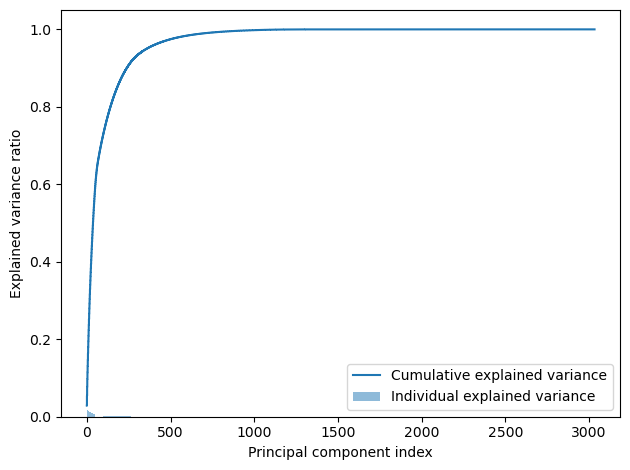

In [53]:
# 1 : PCA

for i in range(1):

    # Instantiate PCA
    n_components = 910
    pca = PCA()

    # Determine transformed features
    X_train_pca = pca.fit_transform(X_deletion)

    # Determine explained variance using explained_variance_ration_ attribute
    exp_var_pca = pca.explained_variance_ratio_

    # Cumulative sum of eigenvalues; This will be used to create step plot
    # for visualizing the variance explained by each principal component.
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    print("Nr of components : ", n_components)
    print("Total Percentage of variance explained = ", cum_sum_eigenvalues[-1] * 100)
    #
    # Create the visualization plot
    #b
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [80]:
pca_components = [140, 180, 237, 355, 697, 1491]
variances = [80, 85, 90, 95, 99, 100]
# % of variance explained: components, 80, 85, 90, 95, 99, 100(up to 6 decimals)

for i, components in enumerate(pca_components):
    
    # Instantiate PCA
    pca = PCA(n_components=components)

    # Determine transformed features
    X_pca = pca.fit_transform(X_deletion)
    X_test_pca = pca.transform(X_test_deletion)
    X_fc_pca = pca.transform(X_fc_deletion)
    
    np.save("./data/pca/tv_{}".format(components), X_pca)
    np.save("./data/pca/test_{}".format(components), X_test_pca)
    np.save("./data/pca/fc_{}".format(components), X_fc_pca)

In [56]:
# Make results dir
# now = datetime.now()
# dt_string = now.strftime("%d-%m-%Y %H:%M:%S")
# save_dir = os.path.join('./results', dt_string)
# os.makedirs(save_dir)

# print("Save dir is ", save_dir)

save_dir = os.path.join('./results', 'PCA')


# # Train model
for p in range(len(pca_components)):
    print("PCA for ", pca_components[p], "components")
    pca_data = np.load("./data/pca/tv_{}.npy".format(pca_components[p]))

    for i in range(len(splits)):
            print("PCA ", (i+1), "of 10")

            train_split, val_split = splits[i]

            x_train = pca_data[train_split]
            x_valid = pca_data[val_split]

            y_train = y_deletion[train_split]
            y_valid = y_deletion[val_split]

            tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="{}/logs/pca".format(save_dir))

            checkpoint_name = save_dir + '/pca_{}_cp{}'.format(pca_components[p], i)
            model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath= checkpoint_name + '.h5',
                monitor="val_loss",
                verbose=0,
                save_best_only=True,
                save_weights_only=False,
                mode="min")

            csv_logger = CSVLogger('{}/pca_{}_{}.log'.format(save_dir, pca_components[p], i), separator=',', append=False)

            model = Sequential()
            model.add(Dense(536,  activation='softmax', input_shape=(x_train.shape[1],), kernel_regularizer=None))
            model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['mse'])
            history = model.fit(x_train, y_train, epochs=100, validation_data=(x_valid, y_valid),
                      callbacks=[
                          tensorboard_callback,
                          model_checkpoint_callback,
                          csv_logger], verbose=0)

PCA for  140 components
PCA  1 of 10
PCA  2 of 10
PCA  3 of 10
PCA  4 of 10
PCA  5 of 10
PCA  6 of 10
PCA  7 of 10
PCA  8 of 10
PCA  9 of 10
PCA  10 of 10
PCA for  180 components
PCA  1 of 10
PCA  2 of 10
PCA  3 of 10
PCA  4 of 10
PCA  5 of 10
PCA  6 of 10
PCA  7 of 10
PCA  8 of 10
PCA  9 of 10
PCA  10 of 10
PCA for  237 components
PCA  1 of 10
PCA  2 of 10
PCA  3 of 10
PCA  4 of 10
PCA  5 of 10
PCA  6 of 10
PCA  7 of 10
PCA  8 of 10
PCA  9 of 10
PCA  10 of 10
PCA for  355 components
PCA  1 of 10
PCA  2 of 10
PCA  3 of 10
PCA  4 of 10
PCA  5 of 10
PCA  6 of 10
PCA  7 of 10
PCA  8 of 10
PCA  9 of 10
PCA  10 of 10
PCA for  697 components
PCA  1 of 10
PCA  2 of 10
PCA  3 of 10
PCA  4 of 10
PCA  5 of 10
PCA  6 of 10
PCA  7 of 10
PCA  8 of 10
PCA  9 of 10
PCA  10 of 10
PCA for  1491 components
PCA  1 of 10
PCA  2 of 10
PCA  3 of 10
PCA  4 of 10
PCA  5 of 10
PCA  6 of 10
PCA  7 of 10
PCA  8 of 10
PCA  9 of 10
PCA  10 of 10


In [83]:
from keras.models import load_model

## Now load in models from results dir and get MSE values
train_losses = []
val_losses = []
test_mse = []
fc_mse = []

for i in range(len(splits)):
    res_log = pd.read_csv("./results/PCA/pca_697_{}.log".format(i))
    train_losses.append(res_log['loss'])
    val_losses.append(res_log['val_loss'])
    
    best_model = load_model("./results/PCA/pca_697_cp{}.h5".format(i))
    test_mse.append(mse(best_model.predict(np.load("/home/bram/lindel423/data/pca/test_697.npy")), y_test_deletion))
    fc_mse.append(mse(best_model.predict(np.load('/home/bram/lindel423/data/pca/fc_697.npy')), y_fc_deletion))
    


In [84]:
print("results test MSE", np.mean(test_mse))
print("results fc MSE", np.mean(fc_mse))

results test MSE 0.00028847292
results fc MSE 0.00033510415


## fc_mse

In [85]:
min_train_losses = []
for run in train_losses:
    min_train_losses.append(np.min(run))

print("min train loss : ", np.mean(min_train_losses))

min_val_losses = []
for run in val_losses:
    min_val_losses.append(np.min(run))
    
print("min val loss : ", np.mean(min_val_losses))

min train loss :  2.535066103935242
min val loss :  3.9847541570663454


In [86]:
## Now for the plotting
# Need 4 values for each epoch: mean, std, min, max

train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

train_mean = np.mean(train_losses, axis=0)
train_std = np.std(train_losses, axis=0)
train_min = np.min(train_losses, axis=0)
train_max = np.max(train_losses, axis=0)

val_mean = np.mean(val_losses, axis=0)
val_std = np.std(val_losses, axis=0)
val_min = np.min(val_losses, axis=0)
val_max = np.max(val_losses, axis=0)

x = np.arange(1, 101)



In [87]:
import matplotlib.pyplot as plt

In [88]:
def early_stopping_epoch(loss, patience=1):
    """Calculate in which epoch ES would have kicked in"""
    
    lowest_loss = 10000 ## A high number
    counter = 0
    epoch = 100
    
    for i in range(len(loss)):
        
        if loss[i] < lowest_loss:
            lowest_loss = loss[i]
            counter = 0
        else:
            if counter >= patience:
                epoch = i + 1 # index at 1
                break
            else:
                counter += 1
            
    
    return epoch
        

In [50]:
val_mean

array([6.12175088, 5.98695984, 5.87238216, 5.77347417, 5.68652921,
       5.60894704, 5.53903308, 5.47560472, 5.41777606, 5.36519027,
       5.31718783, 5.27365432, 5.23410273, 5.19827075, 5.166008  ,
       5.13692985, 5.11076717, 5.08734889, 5.0665555 , 5.04805579,
       5.03154807, 5.01708593, 5.0043406 , 4.99312367, 4.98339329,
       4.97482972, 4.9673419 , 4.96091733, 4.95538259, 4.95065203,
       4.94644642, 4.94295306, 4.93986835, 4.93719954, 4.93492198,
       4.9330348 , 4.93135285, 4.92991872, 4.92865033, 4.9275959 ,
       4.92673965, 4.92596068, 4.92536116, 4.92480621, 4.92438402,
       4.92400041, 4.92373295, 4.92351131, 4.92339287, 4.92328439,
       4.92329392, 4.92323174, 4.92330718, 4.92341881, 4.92356172,
       4.92370648, 4.92387924, 4.92410526, 4.92435584, 4.92457547,
       4.92490478, 4.92521577, 4.92552905, 4.92583785, 4.92615948,
       4.92653823, 4.92696486, 4.92735691, 4.92779078, 4.92819357,
       4.92858901, 4.9290997 , 4.92949166, 4.92995801, 4.93036

25


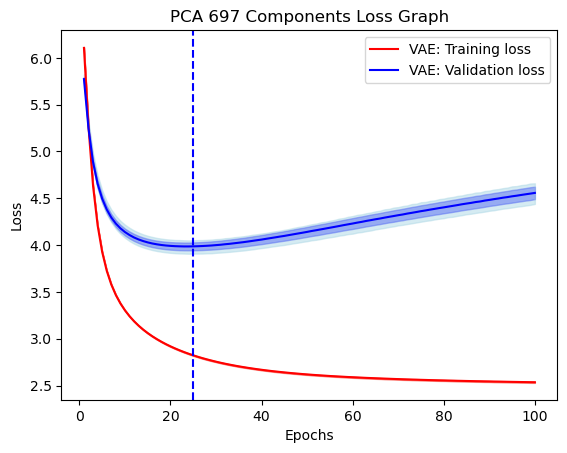

In [90]:
plt.plot(x, train_mean, color="red", label='VAE: Training loss')

plt.fill_between(x, train_mean - train_std, train_mean + train_std, color='red', alpha=0.5)
plt.fill_between(x, train_min, train_max, color='salmon', alpha=0.5)


es_kickin = early_stopping_epoch(val_mean)
print(es_kickin)
plt.axvline(x=es_kickin, color='blue', linestyle='dashed')

plt.plot(x, val_mean, color="blue", label='VAE: Validation loss')

plt.fill_between(x, val_mean - val_std, val_mean + val_std, color='blue', alpha=0.5)
plt.fill_between(x, val_min, val_max, color='lightblue', alpha=0.5)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("PCA 697 Components Loss Graph")

plt.legend()
plt.show()

In [21]:
np.save("./results/vae697/beta0_h_dim[2091, 1394]_val_mean.npy",val_mean)
np.save("./results/vae697/beta0_h_dim[2091, 1394]_val_std.npy", val_std)
np.save("./results/vae697/beta0_h_dim[2091, 1394]_val_min.npy", val_min)
np.save("./results/vae697/beta0_h_dim[2091, 1394]_val_max.npy", val_max)